- voting 1. hard: 다수결 2. soft: 각각의 확률의 평균
- bagging soft인데 각각의 알고리즘에 bootstrapping 독립 추출 한 후 aggregation
- boosting week learner

## sklearn.ensemble.VotingClassifier
* class sklearn.ensemble.VotingClassifier(estimators, *, voting='hard', weights=None, n_jobs=None, flatten_transform=True, verbose=False)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer
import pandas as pd
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data_df.head(3)
import sys
import warnings
warnings.filterwarnings('ignore')



In [11]:
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf), ('KNN',knn_clf)], voting = 'soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, \
    cancer.target, test_size=0.2, random_state=156)

vo_clf.fit(X_train, y_train)
pred=vo_clf.predict(X_test)
print(accuracy_score(y_test, pred))

classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print(class_name, accuracy_score(y_test, pred))

0.9473684210526315
LogisticRegression 0.9385964912280702
KNeighborsClassifier 0.9385964912280702


## sklearn.ensemble.RandomForestClassifier
* class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [19]:
import pandas as pd
feature_name_df = pd.read_csv("./datasets/UCI HAR Dataset/features.txt", \
    sep='\s+', header=None, names=['column_index', 'column_name'])

feature_name = feature_name_df.iloc[:,1].values.tolist()

In [20]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'-'+str(x[1])
                                                                                                            if x[1] > 0 else x[0], axis=1)
    
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백문자를 sep으로 할당
    feature_name_df = pd.read_csv('./datasets/UCI HAR Dataset/features.txt', sep='\s+',
                                                     header=None, names=['column_index', 'column_name'])
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 반환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터세트와 테스트 피처 데이터를 데이터프레임으로 로딩
    # 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./datasets/UCI HAR Dataset/train/X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./datasets/UCI HAR Dataset/test/X_test.txt', sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 데이터 프레임으로 로딩, 컬럼명은 action으로 부여
    y_train = pd.read_csv('./datasets/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./datasets/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 데이터프레임을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf_clf = RandomForestClassifier(random_state=156)

rf_clf.fit(X_train, y_train)

pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
accuracy

0.9236511706820495

In [22]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=156)

In [24]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [6,8,10,12], 'min_samples_split' : [8,16,20]}
grid_cv = GridSearchCV(dt_clf, param_grid=parameters,\
     cv = 5, scoring='accuracy', verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_estimator_)
print(grid_cv.best_params_)
print(grid_cv.best_score_) #0.8548794147162603

Fitting 5 folds for each of 12 candidates, totalling 60 fits
DecisionTreeClassifier(max_depth=8, min_samples_split=16, random_state=156)
{'max_depth': 8, 'min_samples_split': 16}
0.8548794147162603


In [25]:
rf_clf = RandomForestClassifier(random_state=156)
parameters = {'max_depth': [6,8,10,12], 'min_samples_split' : [8,16,20]}
grid_cv = GridSearchCV(rf_clf, param_grid=parameters,\
     cv = 5, scoring='accuracy', verbose=1)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_estimator_)
print(grid_cv.best_params_)
print(grid_cv.best_score_) #0.9179851736751804

Fitting 5 folds for each of 12 candidates, totalling 60 fits
RandomForestClassifier(max_depth=12, min_samples_split=8, random_state=156)
{'max_depth': 12, 'min_samples_split': 8}
0.9179851736751804


0.9212758737699356


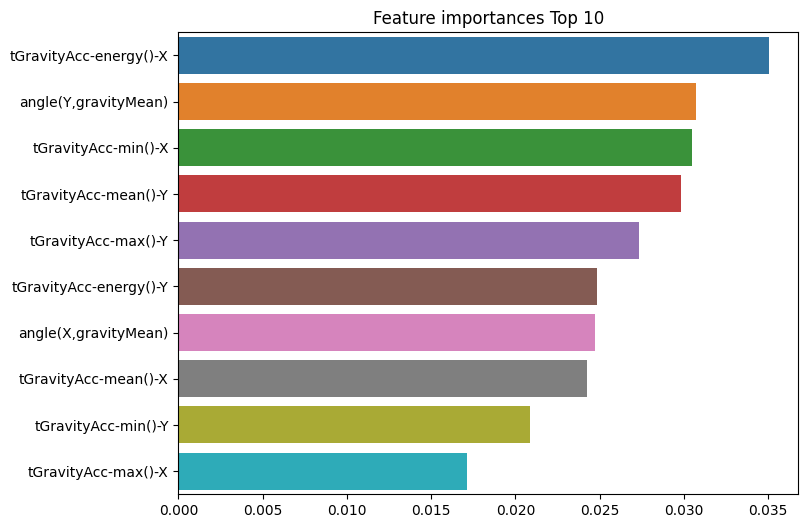

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
print(accuracy_score(y_test,pred1))
ftr_importances_values = best_df_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)

ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 10')
sns.barplot(x=ftr_top10, y= ftr_top10.index)
plt.show()